### High / Low net worth Customer Classification

In [351]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score,recall_score,accuracy_score,precision_score
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings('ignore')

In [65]:
pd.set_option("display.max_columns",None)

In [162]:
train_set=pd.read_csv(r'high_low_networth.csv')

In [163]:
train_set.head()

,REF_NO,children,age_band,status,occupation,occupation_partner,home_status,family_income,self_employed,self_employed_partner,year_last_moved,TVarea,post_code,post_area,Average_Credit_Card_Transaction,Balance_Transfer,Term_Deposit,Life_Insurance,Medical_Insurance,Average_A/C_Balance,Personal_Loan,Investment_in_Mutual_Fund,Investment_Tax_Saving_Bond,Home_Loan,Online_Purchase_Amount,gender,region,Investment_in_Commudity,Investment_in_Equity,Investment_in_Derivative,Portfolio_Balance,Revenue_Grid
0,5466,2,31-35,Partner,Professional,Professional,Own Home,">=35,000",No,No,1981,Meridian,M51 0GU,M51,26.98,29.99,312.25,299.79,88.72,108.85,175.43,134.35,8.98,55.44,7.68,Female,North West,151.55,81.79,136.02,360.37,2
1,9091,Zero,45-50,Partner,Secretarial/Admin,Professional,Own Home,">=35,000",No,No,1997,Meridian,L40 2AG,L40,35.98,74.48,0.00,99.96,10.99,48.45,15.99,0.00,0.00,0.00,18.99,Female,North West,44.28,13.91,29.23,89.22,2
2,9744,1,36-40,Partner,Manual Worker,Manual Worker,Rent Privately,"<22,500, >=20,000",Yes,Yes,1996,HTV,TA19 9PT,TA19,0.00,24.46,0.00,18.44,0.00,0.00,0.02,10.46,0.00,0.00,0.00,Female,South West,8.58,1.75,4.82,14.50,2
3,10700,2,31-35,Partner,Manual Worker,Manual Worker,Own Home,"<25,000, >=22,500",No,No,1990,Scottish TV,FK2 9NG,FK2,44.99,0.00,0.00,0.00,29.99,0.00,0.00,0.00,0.00,0.00,0.00,Female,Scotland,15.00,0.00,5.00,68.98,2
4,1987,Zero,55-60,Partner,Housewife,Professional,Own Home,">=35,000",No,No,1989,Yorkshire,LS23 7DJ,LS23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.98,0.00,0.00,0.00,Female,Unknown,0.00,1.66,1.66,1.88,2


In [164]:
train_set['Revenue_Grid'].value_counts()

Revenue_Grid
2    7264
1     860
Name: count, dtype: int64

In [165]:
train_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   REF_NO                           8124 non-null   int64  
 1   children                         8124 non-null   object 
 2   age_band                         8124 non-null   object 
 3   status                           8124 non-null   object 
 4   occupation                       8124 non-null   object 
 5   occupation_partner               8124 non-null   object 
 6   home_status                      8124 non-null   object 
 7   family_income                    8124 non-null   object 
 8   self_employed                    8124 non-null   object 
 9   self_employed_partner            8124 non-null   object 
 10  year_last_moved                  8124 non-null   int64  
 11  TVarea                           8124 non-null   object 
 12  post_code           

In [293]:
# Separating X and y
# Removing post code and ref_no as post area can be used for analysis and ref_no is unique id

y_main=train_set[['Revenue_Grid']]
x_main=train_set.drop(columns=['Revenue_Grid','post_code','REF_NO'])

#### Data Preprocessing

In [294]:
for z in x_main.columns:
    if x_main[x_main[z]=='Unknown'][z].count() !=0:
        print('Column is:',z)
        print(x_main[x_main[z]=='Unknown'][z].count())

Column is: age_band
44
Column is: status
40
Column is: occupation
449
Column is: occupation_partner
1942
Column is: family_income
108
Column is: TVarea
154
Column is: gender
31
Column is: region
866


In [295]:
# As in columns age_band, status, family income, TVarea, gender and region, the number of Unknowns are less, we shall 
# replace them with mode

columns_2=['age_band','status','family_income','TVarea','gender','region']
for y in columns_2:
    z=str(x_main[y].mode())
    x_main[y]=x_main[y].str.replace('Unknown',z)

In [296]:
# Unknowns in columns occupation an occupation_partner shall be replaced by checking the mode considering the age band as well

retired_age_band=['61-65','65-70','71+']

In [297]:
x_main.loc[(x_main['occupation']=='Unknown') & (x_main['age_band'].isin(retired_age_band)), 'occupation']='Retired'
x_main.loc[(x_main['occupation']=='Unknown'), 'occupation']='Professional'
x_main.loc[(x_main['occupation_partner']=='Unknown') & (x_main['age_band'].isin(retired_age_band)), 'occupation_partner']='Retired'
x_main.loc[(x_main['occupation_partner']=='Unknown'), 'occupation_partner']='Professional'

In [298]:
x_main['age_band'].value_counts()

age_band
45-50                                        1098
41-45                                         903
36-40                                         895
55-60                                         865
31-35                                         840
51-55                                         833
26-30                                         735
61-65                                         700
65-70                                         468
22-25                                         356
71+                                           337
18-21                                          50
0    45-50\nName: age_band, dtype: object      44
Name: count, dtype: int64

In [299]:
x_main['age_band'] = x_main['age_band'].str.replace('0    45-50\ndtype: object','45-50',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('0    45-50\nName: age_band, dtype: object','45-50',regex=False)

In [300]:
x_main['age_band'].value_counts()

age_band
45-50    1142
41-45     903
36-40     895
55-60     865
31-35     840
51-55     833
26-30     735
61-65     700
65-70     468
22-25     356
71+       337
18-21      50
Name: count, dtype: int64

In [301]:
# Splitting column age band to upper columns

x_main['age_band'] = x_main['age_band'].str.replace('45-50','50',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('41-45','45',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('36-40','40',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('55-60','60',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('31-35','35',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('51-55','55',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('26-30','30',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('61-65','65',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('65-70','70',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('22-25','25',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('71+','71',regex=False)
x_main['age_band'] = x_main['age_band'].str.replace('18-21','21',regex=False)

In [302]:
x_main['age_band'].value_counts()

age_band
50    1142
45     903
40     895
60     865
35     840
55     833
30     735
65     700
70     468
25     356
71     337
21      50
Name: count, dtype: int64

In [303]:
# Converting the column to numeric data types

x_main[['age_band']] = x_main[['age_band']].apply(pd.to_numeric)

In [304]:
salary_1=['<22,500, >=20,000', '<25,000, >=22,500','<30,000, >=27,500', '<20,000, >=17,500', '<27,500, >=25,000','< 4,000', '<15,000, >=12,500', '<17,500, >=15,000',
       '< 8,000, >= 4,000', '<12,500, >=10,000', '<10,000, >= 8,000']

In [305]:
# Splitting column family income to upper and lower limit columns

x_main['family_income'] = x_main['family_income'].str.replace('>=35,000','35000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<22,500, >=20,000','22500',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<25,000, >=22,500','25000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<30,000, >=27,500','30000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<20,000, >=17,500','20000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<27,500, >=25,000','27500',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('< 4,000','4000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<15,000, >=12,500','15000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<17,500, >=15,000','17500',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('< 8,000, >= 4,000','8000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<12,500, >=10,000','12500',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('<10,000, >= 8,000','10000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('0    35000\ndtype: object','35000',regex=False)
x_main['family_income'] = x_main['family_income'].str.replace('0    35000\nName: family_income, dtype: object','35000',regex=False)

In [306]:
x_main['family_income'].value_counts()

family_income
35000    2122
27500     969
30000     796
25000     656
12500     535
20000     525
17500     521
15000     508
22500     479
10000     452
8000      328
4000      233
Name: count, dtype: int64

In [307]:
# Converting the column to numeric data types

x_main[['family_income']] = x_main[['family_income']].apply(pd.to_numeric)

In [308]:
# Cleaning the columns 

x_main['status'] = x_main['status'].str.replace('0    Partner\ndtype: object','Partner',regex=False)
x_main.loc[x_main['year_last_moved']==0,'year_last_moved']=1997
x_main['TVarea'] = x_main['TVarea'].str.replace('0    Central\ndtype: object','Central',regex=False)
x_main['gender'] = x_main['gender'].str.replace('0    Female\ndtype: object','Female',regex=False)
x_main['region'] = x_main['region'].str.replace('0    South East\ndtype: object','South East',regex=False)

In [309]:
# Changing children column to numeric

x_main['children'] = x_main['children'].str.replace('Zero','0',regex=False)
x_main['children'] = x_main['children'].str.replace('4+','4',regex=False)
x_main[['children']] = x_main[['children']].apply(pd.to_numeric)

In [310]:
x_main.columns

Index(['children', 'age_band', 'status', 'occupation', 'occupation_partner',
       'home_status', 'family_income', 'self_employed',
       'self_employed_partner', 'year_last_moved', 'TVarea', 'post_area',
       'Average_Credit_Card_Transaction', 'Balance_Transfer', 'Term_Deposit',
       'Life_Insurance', 'Medical_Insurance', 'Average_A/C_Balance',
       'Personal_Loan', 'Investment_in_Mutual_Fund',
       'Investment_Tax_Saving_Bond', 'Home_Loan', 'Online_Purchase_Amount',
       'gender', 'region', 'Investment_in_Commudity', 'Investment_in_Equity',
       'Investment_in_Derivative', 'Portfolio_Balance'],
      dtype='object')

In [311]:
# Outlier detection

num_cols = x_main[['Average_Credit_Card_Transaction', 'Balance_Transfer', 'Term_Deposit',
       'Life_Insurance', 'Medical_Insurance', 'Average_A/C_Balance',
       'Personal_Loan', 'Investment_in_Mutual_Fund',
       'Investment_Tax_Saving_Bond', 'Home_Loan', 'Online_Purchase_Amount',
        'Investment_in_Commudity', 'Investment_in_Equity',
       'Investment_in_Derivative', 'Portfolio_Balance']]

Q1 = num_cols.quantile(0.25)
Q3 = num_cols.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [312]:
# Checking the count of outliers

for x in num_cols.columns:
    print('column is:',x)
    print('min side outliers count is:')
    print(num_cols[num_cols[x] < lower_bound[x]][x].count())
    print('max side outliers count is:')
    print(num_cols[num_cols[x] > upper_bound[x]][x].count())
    print('-'*40)
    
# There are outliers in columns Average_Credit_Card_Transaction, Balance_Transfer, Term_Deposit, Life_Insurance,
# Medical_Insurance, Average_A/C_Balance, Personal_Loan,Investment_in_Mutual_Fund,Investment_Tax_Saving_Bond,
# Home_Loan,Online_Purchase_Amount, Investment_in_Commudity, Investment_in_Equity,Investment_in_Derivative, Portfolio_Balance

column is: Average_Credit_Card_Transaction
min side outliers count is:
0
max side outliers count is:
1046
----------------------------------------
column is: Balance_Transfer
min side outliers count is:
0
max side outliers count is:
573
----------------------------------------
column is: Term_Deposit
min side outliers count is:
0
max side outliers count is:
752
----------------------------------------
column is: Life_Insurance
min side outliers count is:
0
max side outliers count is:
446
----------------------------------------
column is: Medical_Insurance
min side outliers count is:
0
max side outliers count is:
599
----------------------------------------
column is: Average_A/C_Balance
min side outliers count is:
0
max side outliers count is:
459
----------------------------------------
column is: Personal_Loan
min side outliers count is:
0
max side outliers count is:
1120
----------------------------------------
column is: Investment_in_Mutual_Fund
min side outliers count is:
0
max 

In [313]:
# Capping outliers with upper bound

for x in num_cols.columns:
    x_main.loc[x_main[x] > upper_bound[x],x] = upper_bound[x]

#### EDA

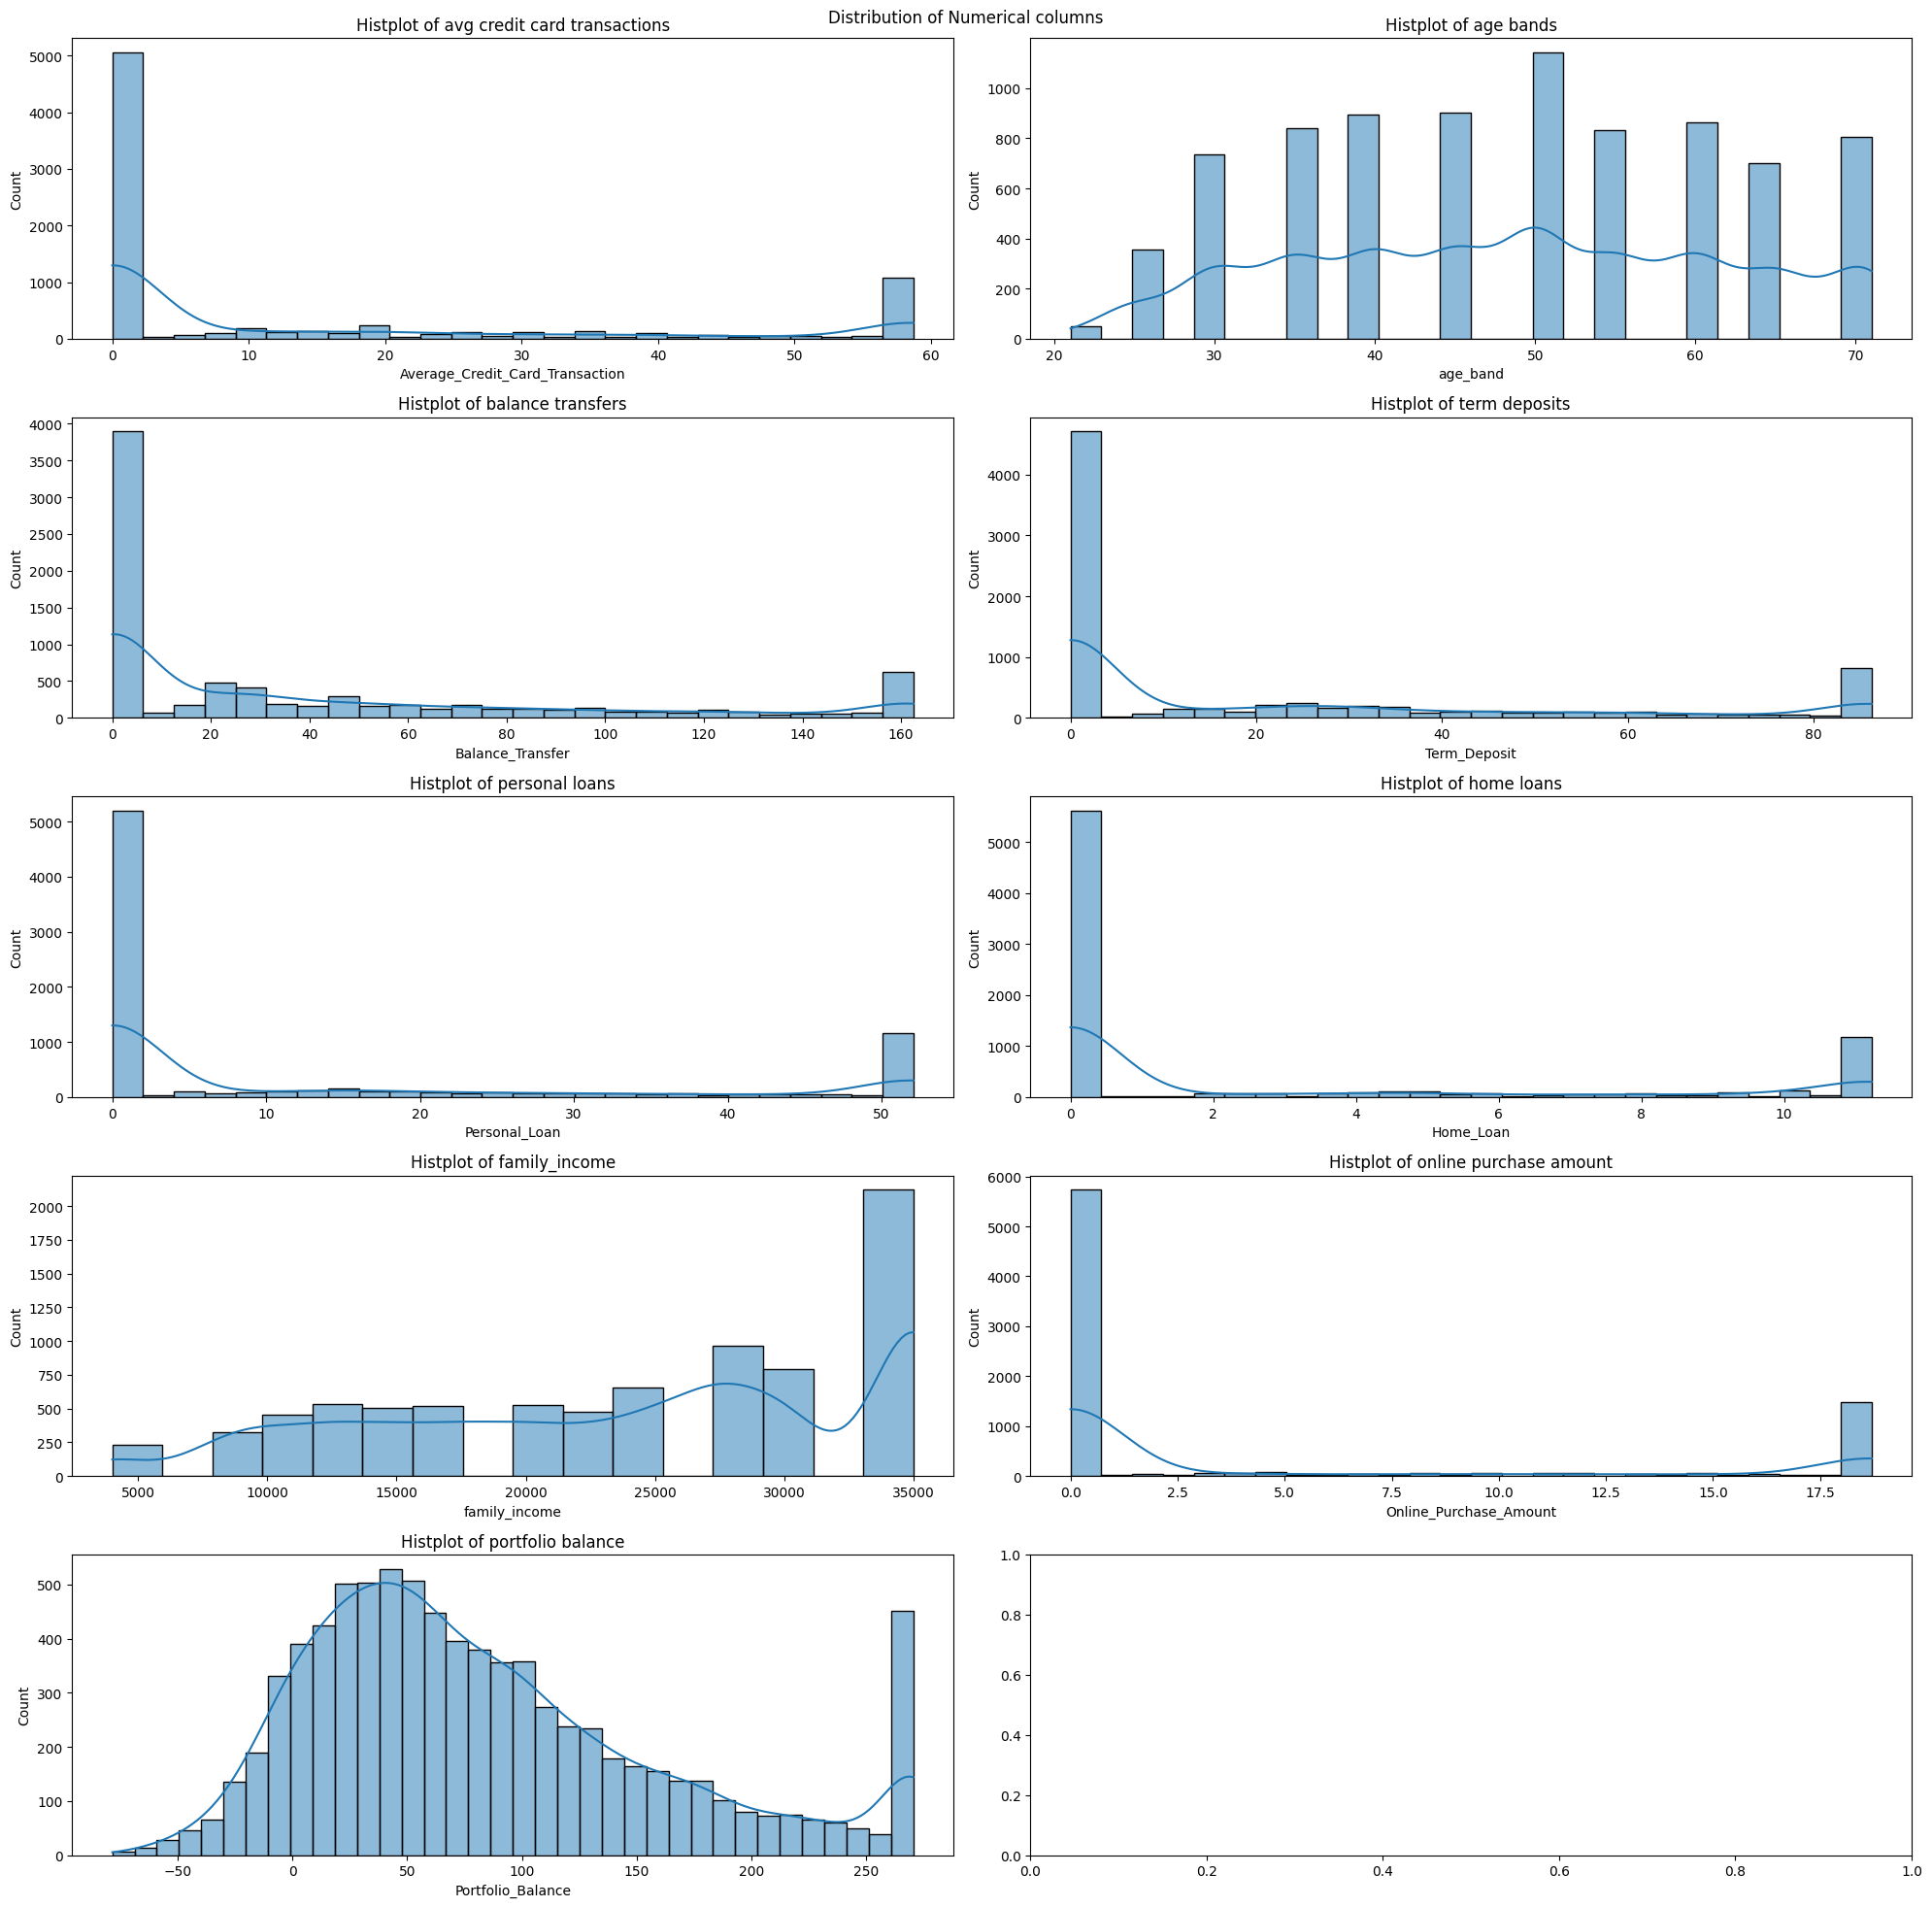

In [314]:
fig,axes=plt.subplots(5,2,figsize=(20,20))
fig.suptitle('Distribution of Numerical columns')
sns.histplot(data=x_main,x='Average_Credit_Card_Transaction',palette="Set3",ax=axes[0,0],kde=True).set(title="Histplot of avg credit card transactions")
sns.histplot(data=x_main,x='age_band',palette="Set3",ax=axes[0,1],kde=True).set(title="Histplot of age bands")
sns.histplot(data=x_main,x='Balance_Transfer',palette="Set3",ax=axes[1,0],kde=True).set(title="Histplot of balance transfers")
sns.histplot(data=x_main,x='Term_Deposit',palette="Set3",ax=axes[1,1],kde=True).set(title="Histplot of term deposits")
sns.histplot(data=x_main,x='Personal_Loan',palette="Set3",ax=axes[2,0],kde=True).set(title="Histplot of personal loans")
sns.histplot(data=x_main,x='Home_Loan',palette="Set3",ax=axes[2,1],kde=True).set(title="Histplot of home loans")
sns.histplot(data=x_main,x='family_income',palette="Set3",ax=axes[3,0],kde=True).set(title="Histplot of family_income")
sns.histplot(data=x_main,x='Online_Purchase_Amount',palette="Set3",ax=axes[3,1],kde=True).set(title="Histplot of online purchase amount")
sns.histplot(data=x_main,x='Portfolio_Balance',palette="Set3",ax=axes[4,0],kde=True).set(title="Histplot of portfolio balance")

fig.tight_layout()


Text(0.5, 1.0, 'self_employed_partner')

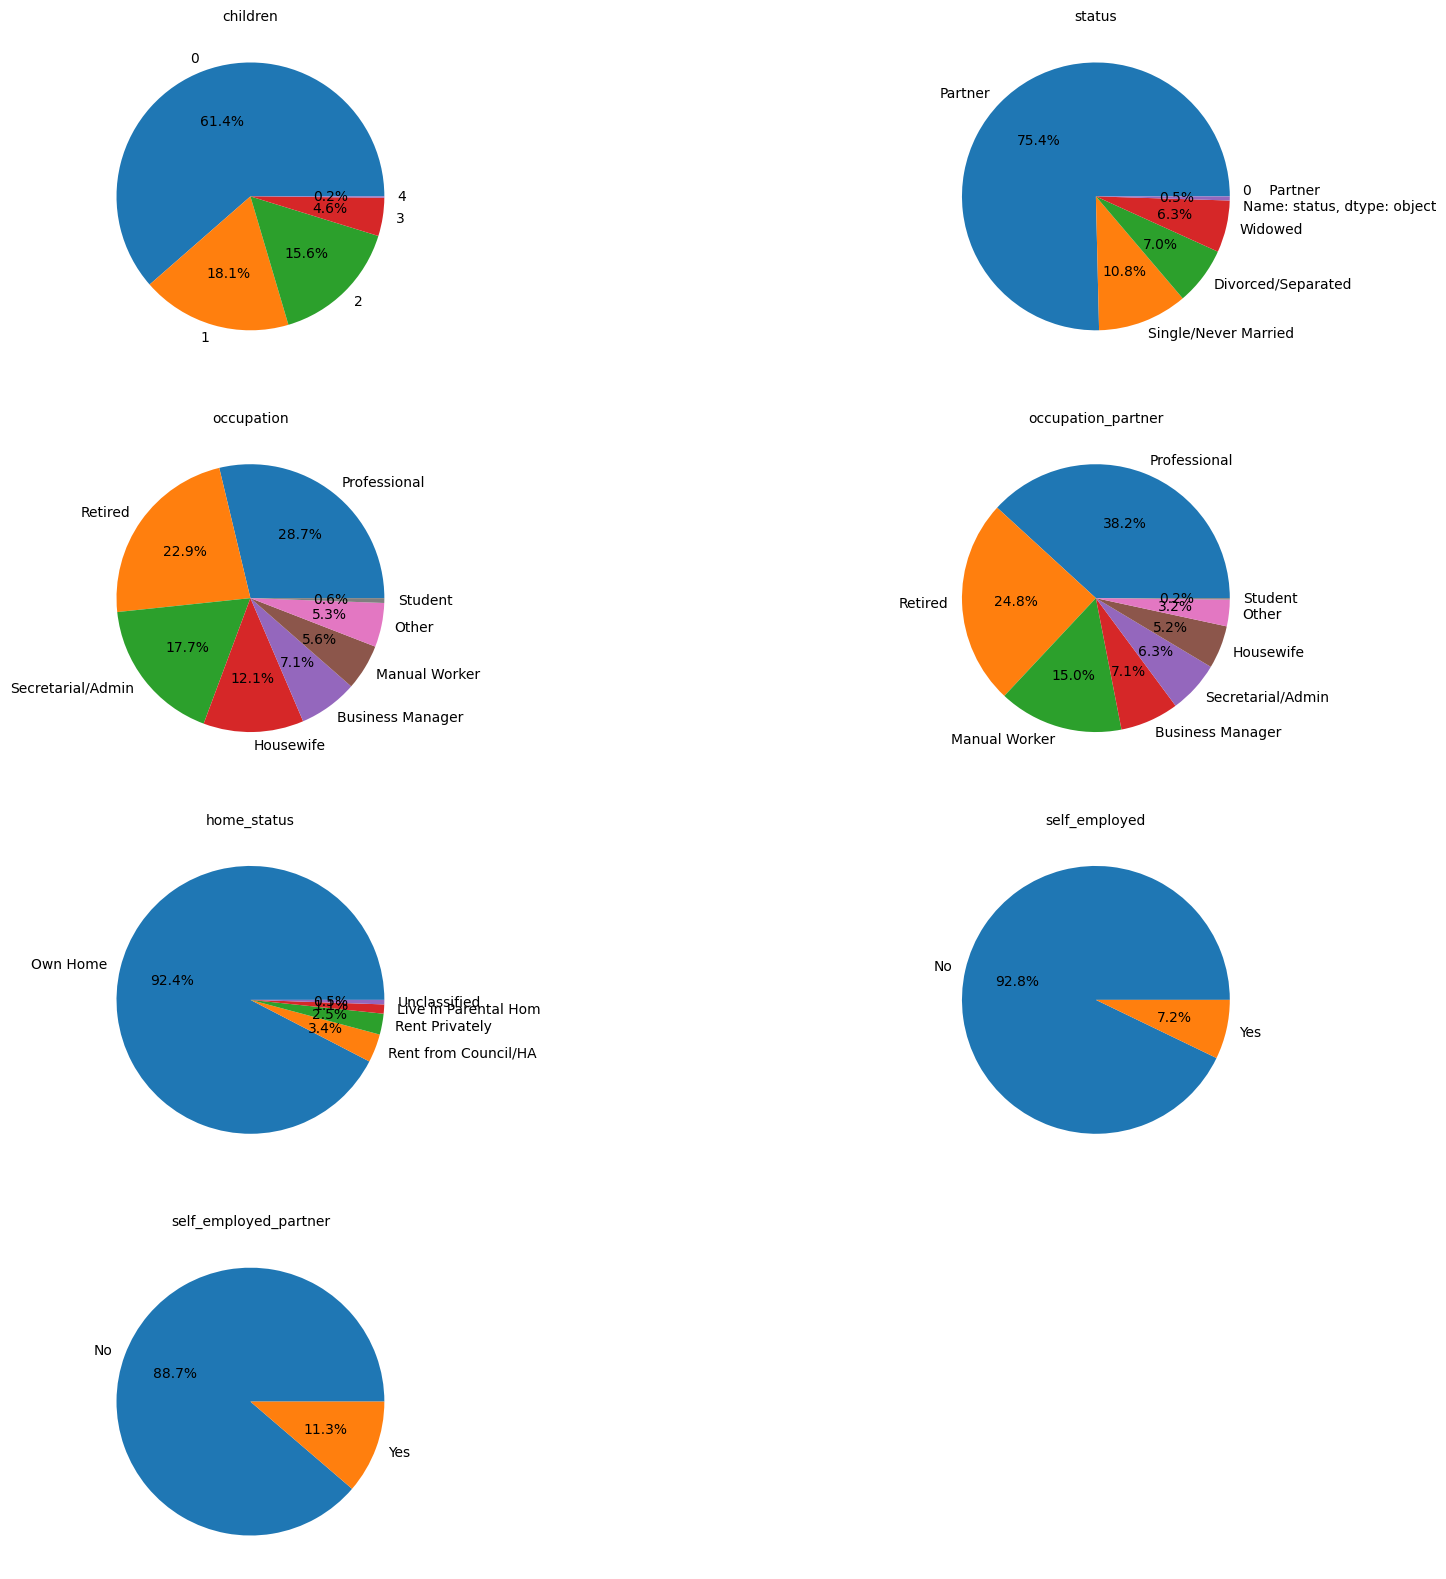

In [315]:
plt.figure(figsize=(20,20))
fig.tight_layout()
plt.subplot(4,2,1)
plt.pie(x_main['children'].value_counts(),labels=x_main['children'].value_counts().index,autopct="%.1f%%")
plt.title('children',fontsize=10)
plt.subplot(4,2,2)
plt.pie(x_main['status'].value_counts(),labels=x_main['status'].value_counts().index,autopct="%.1f%%")
plt.title('status',fontsize=10)
plt.subplot(4,2,3)
plt.pie(x_main['occupation'].value_counts(),labels=x_main['occupation'].value_counts().index,autopct="%.1f%%")
plt.title('occupation',fontsize=10)
plt.subplot(4,2,4)
plt.pie(x_main['occupation_partner'].value_counts(),labels=x_main['occupation_partner'].value_counts().index,autopct="%.1f%%")
plt.title('occupation_partner',fontsize=10)
plt.subplot(4,2,5)
plt.pie(x_main['home_status'].value_counts(),labels=x_main['home_status'].value_counts().index,autopct="%.1f%%")
plt.title('home_status',fontsize=10)
plt.subplot(4,2,6)
plt.pie(x_main['self_employed'].value_counts(),labels=x_main['self_employed'].value_counts().index,autopct="%.1f%%")
plt.title('self_employed',fontsize=10)
plt.subplot(4,2,7)
plt.pie(x_main['self_employed_partner'].value_counts(),labels=x_main['self_employed_partner'].value_counts().index,autopct="%.1f%%")
plt.title('self_employed_partner',fontsize=10)

# Most of the people have 0 zero children
# Almost 75.9% of people have partners
# Majority of people are either professionals or retired
# Majority of people have partners that are professionals
# 92.4% of people own houses
# 92.8% of people are not self employed
# 88.7% of people do not have self employed partners

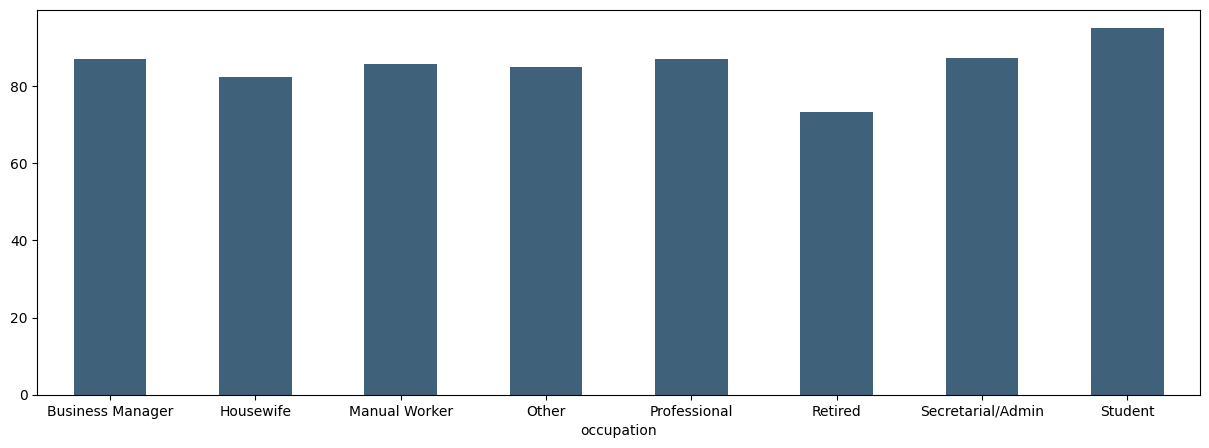

In [316]:
# How is the portfolio balance varying among differnt occupations?

plt.figure(figsize=(15,5))
x_main.groupby('occupation')['Portfolio_Balance'].mean().plot(kind='bar',color='#3F617A')
plt.xticks(rotation=0)
plt.show()

# From below graph, students have the highest portfolio balance and retired people have the least.

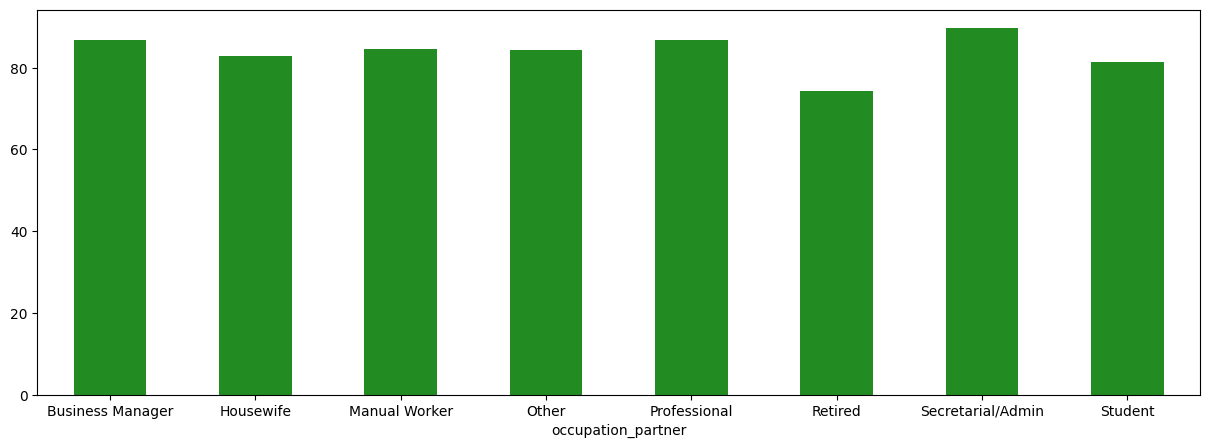

In [317]:
# How is portfolio balance varying with occupation of the partner

plt.figure(figsize=(15,5))
x_main.groupby('occupation_partner')['Portfolio_Balance'].mean().plot(kind='bar',color='#228B22')
plt.xticks(rotation=0)
plt.show()

# Portfolio balance is highest for people with partner of occupation Secretarial/Admin and least for retired partners

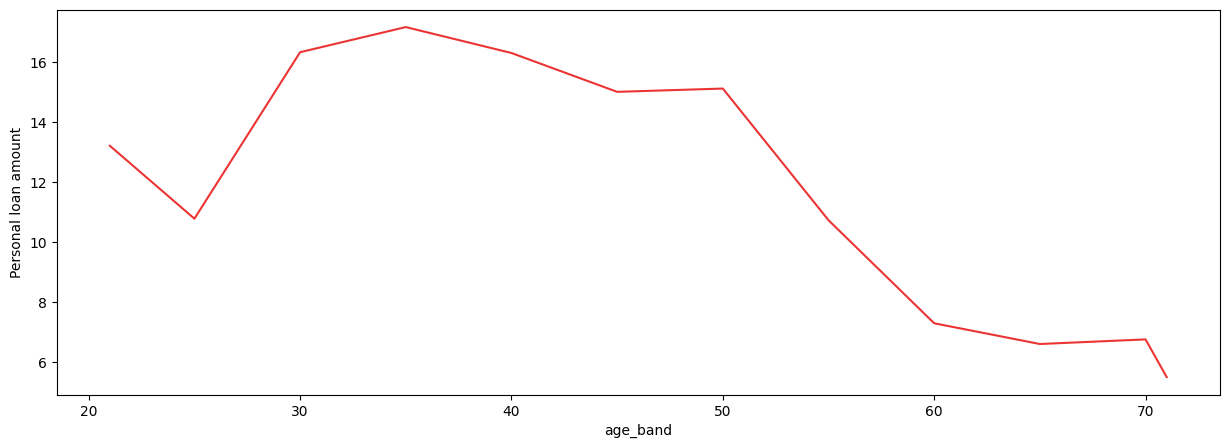

In [318]:
# How does age groups vary with personal loan

plt.figure(figsize=(15,5))
x_main.groupby(by='age_band')['Personal_Loan'].mean().plot(kind = 'line',color = '#eb3434')
plt.ylabel('Personal loan amount')
plt.show()

# Personal loan is mostly talen by people between agen 30 and 50. After 50 years of age, personal loan amount decreases

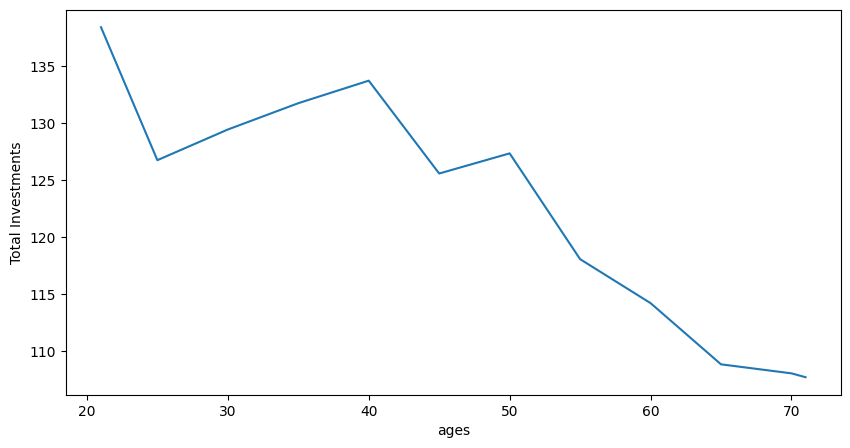

In [319]:
# How are investments varying with poeple of different ages

plt.figure(figsize=(10,5))
temp_df = pd.DataFrame()
temp_df['Investments'] = x_main['Investment_Tax_Saving_Bond'] + x_main['Investment_in_Commudity']+x_main['Investment_in_Derivative']+x_main['Investment_in_Equity']+x_main['Investment_in_Mutual_Fund']
temp_df['ages'] = x_main['age_band']
temp_df.groupby('ages')['Investments'].mean().plot(kind='line')
plt.ylabel('Total Investments')
plt.show()

# As age increases, total investments decreases

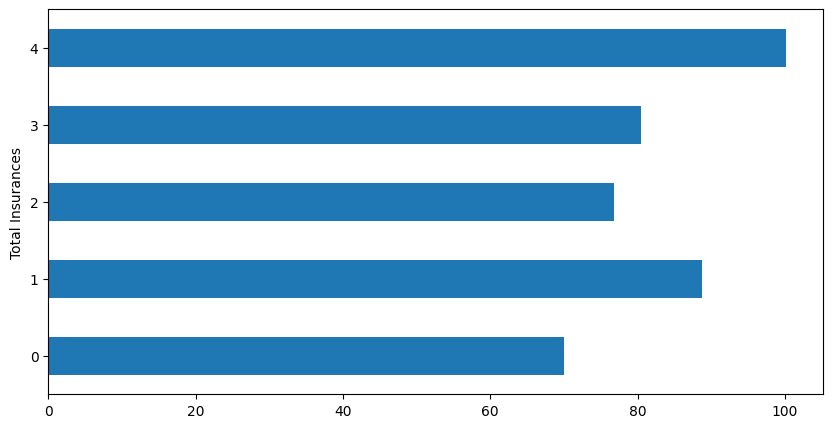

In [320]:
# How are insurances varying with people of different number of children

plt.figure(figsize=(10,5))
temp_df['Insurances'] = x_main['Life_Insurance']+x_main['Medical_Insurance']
temp_df['children'] = x_main['children']
temp_df.groupby('children')['Insurances'].mean().plot(kind='barh')
plt.ylabel('Total Insurances')
plt.show()

# People with 4 or more children have highest insurances and people with 0 children have least insurances 

In [321]:
num_cols = x_main[['Average_Credit_Card_Transaction', 'Balance_Transfer', 'Term_Deposit',
       'Life_Insurance', 'Medical_Insurance', 'Average_A/C_Balance',
       'Personal_Loan', 'Investment_in_Mutual_Fund',
       'Investment_Tax_Saving_Bond', 'Home_Loan', 'Online_Purchase_Amount',
        'Investment_in_Commudity', 'Investment_in_Equity',
       'Investment_in_Derivative', 'Portfolio_Balance']]

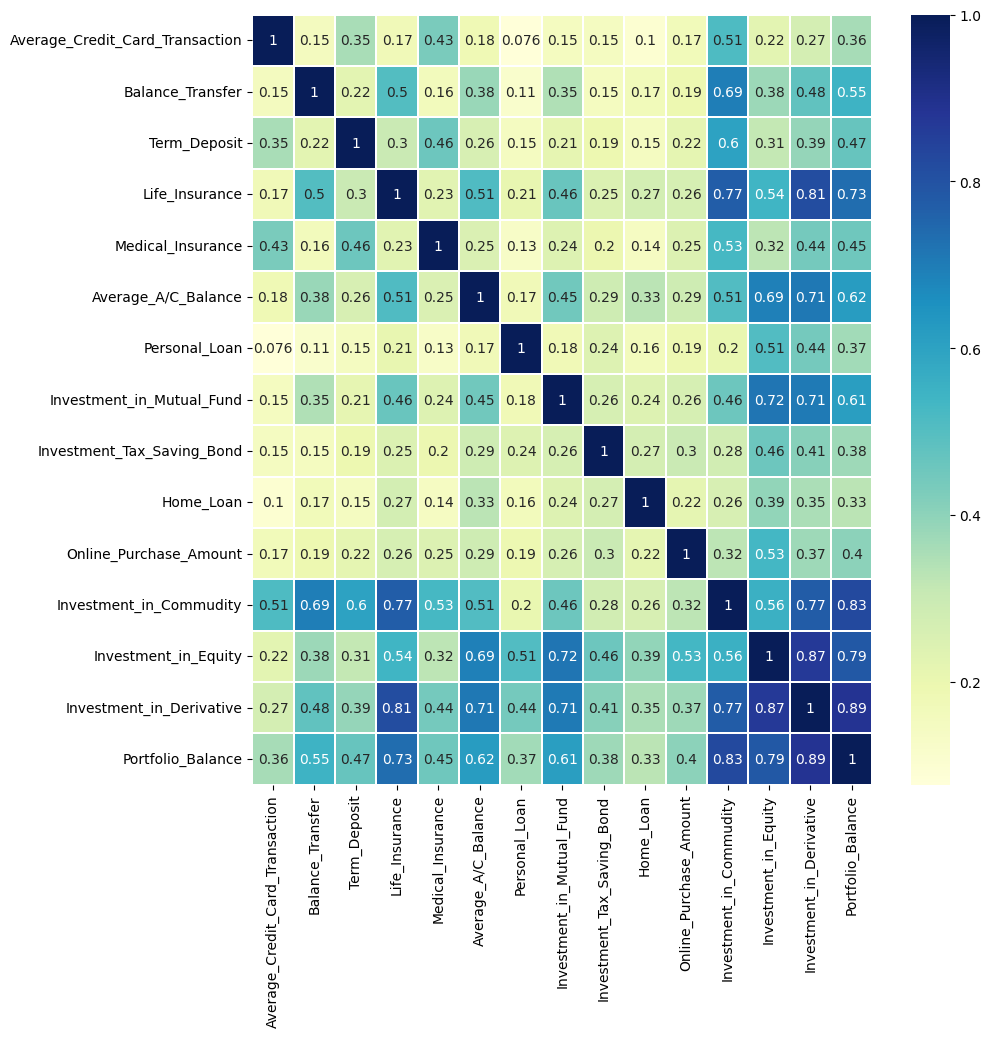

In [322]:
plt.figure(figsize=(10,10))
df_corr = sns.heatmap(num_cols.corr(),annot=True,cmap ="YlGnBu",linewidths = 0.1)
plt.show()

# There is a high correlation due to few columns

#### Feature Engineering

In [323]:
# x_main['Investments'] = x_main['Investment_in_Commudity'] + x_main['Investment_in_Derivative']+x_main['Investment_in_Equity']+x_main['Investment_in_Mutual_Fund']+x_main['Investment_Tax_Saving_Bond']
# x_main.drop(['Investment_in_Commudity','Investment_in_Derivative','Investment_in_Equity','Investment_in_Mutual_Fund','Investment_Tax_Saving_Bond'],axis=1,inplace=True)

In [324]:
x_main.drop(['year_last_moved','TVarea'],inplace=True,axis=1)
x_main.drop(['post_area'],inplace=True,axis=1)

#### One hot encoding for all the categorical columns

In [325]:
cat_cols =list(['status', 'occupation', 'occupation_partner', 'home_status',
       'self_employed', 'self_employed_partner', 'gender','region'
       ])

In [326]:
encoded_cols = pd.get_dummies(data=x_main,columns=cat_cols,drop_first=True,dtype='int')
encoded_cols = pd.DataFrame(encoded_cols)

In [327]:
encoded_cols.head()

,children,age_band,family_income,Average_Credit_Card_Transaction,Balance_Transfer,Term_Deposit,Life_Insurance,Medical_Insurance,Average_A/C_Balance,Personal_Loan,Investment_in_Mutual_Fund,Investment_Tax_Saving_Bond,Home_Loan,Online_Purchase_Amount,Investment_in_Commudity,Investment_in_Equity,Investment_in_Derivative,Portfolio_Balance,status_Divorced/Separated,status_Partner,status_Single/Never Married,status_Widowed,occupation_Housewife,occupation_Manual Worker,occupation_Other,occupation_Professional,occupation_Retired,occupation_Secretarial/Admin,occupation_Student,occupation_partner_Housewife,occupation_partner_Manual Worker,occupation_partner_Other,occupation_partner_Professional,occupation_partner_Retired,occupation_partner_Secretarial/Admin,occupation_partner_Student,home_status_Own Home,home_status_Rent Privately,home_status_Rent from Council/HA,home_status_Unclassified,self_employed_Yes,self_employed_partner_Yes,gender_Female,gender_Male,region_Channel Islands,region_East Anglia,region_East Midlands,region_Isle of Man,region_North,region_North West,region_Northern Ireland,region_Scotland,region_South East,region_South West,region_Wales,region_West Midlands
0,2,35,35000,26.98,29.99,86.225,232.21875,67.425,108.85,52.06875,134.35,8.98,11.225,7.68,112.06375,62.94125,92.87125,270.50875,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,50,35000,35.98,74.48,0.000,99.96000,10.990,48.45,15.99000,0.00,0.00,0.000,18.70,44.28000,13.91000,29.23000,89.22000,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,40,22500,0.00,24.46,0.000,18.44000,0.000,0.00,0.02000,10.46,0.00,0.000,0.00,8.58000,1.75000,4.82000,14.50000,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2,35,25000,44.99,0.00,0.000,0.00000,29.990,0.00,0.00000,0.00,0.00,0.000,0.00,15.00000,0.00000,5.00000,68.98000,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,60,35000,0.00,0.00,0.000,0.00000,0.000,0.00,0.00000,9.98,0.00,0.000,0.00,0.00000,1.66000,1.66000,1.88000,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Using min max scaler for numerical columns

In [328]:
num_cols=x_main[['Average_Credit_Card_Transaction', 'Balance_Transfer', 'Term_Deposit',
       'Life_Insurance', 'Medical_Insurance', 'Average_A/C_Balance',
       'Personal_Loan', 'Investment_in_Mutual_Fund',
       'Investment_Tax_Saving_Bond', 'Home_Loan', 'Online_Purchase_Amount',
        'Investment_in_Commudity', 'Investment_in_Equity',
       'Investment_in_Derivative', 'Portfolio_Balance','family_income','age_band']]

In [329]:
mm=MinMaxScaler()
scaled_num_cols = mm.fit_transform(num_cols)
scaled_num_cols = pd.DataFrame(scaled_num_cols,columns=num_cols.columns,index = num_cols.index)

In [330]:
scaled_num_cols.head()

,Average_Credit_Card_Transaction,Balance_Transfer,Term_Deposit,Life_Insurance,Medical_Insurance,Average_A/C_Balance,Personal_Loan,Investment_in_Mutual_Fund,Investment_Tax_Saving_Bond,Home_Loan,Online_Purchase_Amount,Investment_in_Commudity,Investment_in_Equity,Investment_in_Derivative,Portfolio_Balance,family_income,age_band
0,0.459625,0.184582,1.0,1.000000,1.000000,0.948119,1.000000,0.904105,0.654281,1.0,0.410695,1.000000,1.000000,1.000000,1.000000,1.000000,0.28
1,0.612947,0.458409,0.0,0.430456,0.162996,0.422015,0.307094,0.000000,0.000000,0.0,1.000000,0.395132,0.221000,0.314737,0.480457,1.000000,0.58
2,0.000000,0.150546,0.0,0.079408,0.000000,0.000000,0.000384,0.070390,0.000000,0.0,0.000000,0.076564,0.027804,0.051900,0.266322,0.596774,0.38
3,0.766440,0.000000,0.0,0.000000,0.444791,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.133852,0.000000,0.053838,0.422452,0.677419,0.28
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.067160,0.000000,0.0,0.000000,0.000000,0.026374,0.017874,0.230155,1.000000,0.78


In [331]:
for x in num_cols.columns:
    encoded_cols[x] = scaled_num_cols[x]

In [332]:
encoded_cols.head()

,children,age_band,family_income,Average_Credit_Card_Transaction,Balance_Transfer,Term_Deposit,Life_Insurance,Medical_Insurance,Average_A/C_Balance,Personal_Loan,Investment_in_Mutual_Fund,Investment_Tax_Saving_Bond,Home_Loan,Online_Purchase_Amount,Investment_in_Commudity,Investment_in_Equity,Investment_in_Derivative,Portfolio_Balance,status_Divorced/Separated,status_Partner,status_Single/Never Married,status_Widowed,occupation_Housewife,occupation_Manual Worker,occupation_Other,occupation_Professional,occupation_Retired,occupation_Secretarial/Admin,occupation_Student,occupation_partner_Housewife,occupation_partner_Manual Worker,occupation_partner_Other,occupation_partner_Professional,occupation_partner_Retired,occupation_partner_Secretarial/Admin,occupation_partner_Student,home_status_Own Home,home_status_Rent Privately,home_status_Rent from Council/HA,home_status_Unclassified,self_employed_Yes,self_employed_partner_Yes,gender_Female,gender_Male,region_Channel Islands,region_East Anglia,region_East Midlands,region_Isle of Man,region_North,region_North West,region_Northern Ireland,region_Scotland,region_South East,region_South West,region_Wales,region_West Midlands
0,2,0.28,1.000000,0.459625,0.184582,1.0,1.000000,1.000000,0.948119,1.000000,0.904105,0.654281,1.0,0.410695,1.000000,1.000000,1.000000,1.000000,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
1,0,0.58,1.000000,0.612947,0.458409,0.0,0.430456,0.162996,0.422015,0.307094,0.000000,0.000000,0.0,1.000000,0.395132,0.221000,0.314737,0.480457,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
2,1,0.38,0.596774,0.000000,0.150546,0.0,0.079408,0.000000,0.000000,0.000384,0.070390,0.000000,0.0,0.000000,0.076564,0.027804,0.051900,0.266322,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0
3,2,0.28,0.677419,0.766440,0.000000,0.0,0.000000,0.444791,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.133852,0.000000,0.053838,0.422452,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0.78,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.067160,0.000000,0.0,0.000000,0.000000,0.026374,0.017874,0.230155,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Train Test Split-Model

In [333]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(encoded_cols,y_main,test_size=0.25)

In [334]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((6093, 56), (2031, 56), (6093, 1), (2031, 1))

#### Logistic regression

In [335]:
logreg=LogisticRegression(max_iter=1000)
model = logreg.fit(X_train,y_train)

In [336]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

In [337]:
f1_log_train = f1_score(y_train, y_pred_train)
f1_log_test = f1_score(y_test, y_pred_test)
acc_log_train = accuracy_score(y_train, y_pred_train)
acc_log_test = accuracy_score(y_test, y_pred_test)
recall_log_train = recall_score(y_train, y_pred_train)
recall_log_test = recall_score(y_test, y_pred_test)
precision_log_train = precision_score(y_train, y_pred_train)
precision_log_test = precision_score(y_test, y_pred_test)

In [338]:
f1_log_train,f1_log_test

(0.3934782608695653, 0.4112149532710281)

In [339]:
acc_log_train,acc_log_test

(0.9084194977843427, 0.9069423929098966)

In [340]:
recall_log_train,recall_log_test

(0.2828125, 0.3)

In [341]:
precision_log_train,precision_log_test

(0.6464285714285715, 0.6534653465346535)

In [349]:
import statsmodels.api as sm

y_main_summary=pd.DataFrame()
X = sm.add_constant(encoded_cols)
y_main_summary['Revenue_Grid'] = y_main['Revenue_Grid'].replace({1: 0, 2: 1})

In [352]:
logit_model = sm.Logit(y_main_summary, encoded_cols)
logit_result = logit_model.fit()
print(logit_result.summary())

# There are many columns whose p value is greater than 0.05.
# 

         Current function value: 0.220408
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:           Revenue_Grid   No. Observations:                 8124
Model:                          Logit   Df Residuals:                     8068
Method:                           MLE   Df Model:                           55
Date:                Thu, 11 Jan 2024   Pseudo R-squ.:                  0.3475
Time:                        06:41:30   Log-Likelihood:                -1790.6
converged:                      False   LL-Null:                       -2744.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
children                                -0.0141      0.057     -0.248      0.804      -0.126

#### KNN Classifier

In [353]:
f1_train_list = []
f1_test_list = []

k_value = list(np.arange(1,30,2))
for x in k_value:
    knn = KNeighborsClassifier(n_neighbors=x)
    model_knn = knn.fit(X_train,y_train)
    y_pred_train = model_knn.predict(X_train)
    y_pred_test = model_knn.predict(X_test)

    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)

    f1_train_list.append(f1_train)
    f1_test_list.append(f1_test)    

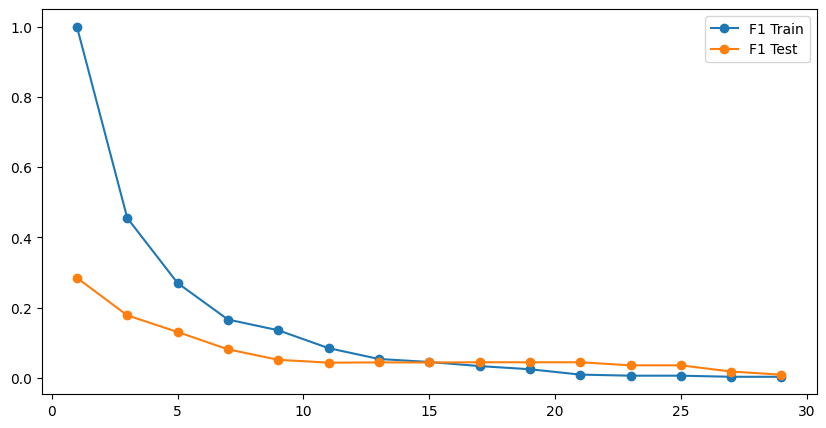

In [354]:
plt.figure(figsize=(10,5))
plt.plot(k_value , f1_train_list,marker='o',label = 'F1 Train')
plt.plot(k_value , f1_test_list,marker='o',label = 'F1 Test')
plt.legend()
plt.show()

In [355]:
knn = KNeighborsClassifier(n_neighbors=9)
model = knn.fit(X_train,y_train)

In [356]:
y_pred_train=model.predict(X_train)
y_pred_test=model.predict(X_test)

In [357]:
f1_knn_train = f1_score(y_train, y_pred_train)
f1_knn_test = f1_score(y_test, y_pred_test)
acc_knn_train = accuracy_score(y_train, y_pred_train)
acc_knn_test = accuracy_score(y_test, y_pred_test)
recall_knn_train = recall_score(y_train, y_pred_train)
recall_knn_test = recall_score(y_test, y_pred_test)
precision_knn_train = precision_score(y_train, y_pred_train)
precision_knn_test = precision_score(y_test, y_pred_test)

In [358]:
f1_knn_train,f1_knn_test

(0.13559322033898305, 0.05150214592274678)

In [359]:
acc_knn_train,acc_knn_test

(0.8995568685376661, 0.8911866075824717)

In [360]:
recall_knn_train,recall_knn_test

(0.075, 0.02727272727272727)

In [361]:
precision_knn_train,precision_knn_test

(0.7058823529411765, 0.46153846153846156)

#### Results

In [362]:
accuracy = np.round(np.array([acc_log_test, acc_knn_test]),3)
precision =np.round(np.array([precision_log_test, precision_knn_test]),3)
recall =np.round( np.array([recall_log_test, recall_knn_test]),3)
f_1 = np.round(np.array([f1_log_test, f1_knn_test]),3)
models = np.array(['Logistic Regression', 'KNN'])
results = pd.DataFrame(np.column_stack((models, accuracy, precision, recall, f_1)),
                       columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
results

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.907,0.653,0.3,0.411
1,KNN,0.891,0.462,0.027,0.052


In [363]:
# From above table, it can be infered that Logistic regression performs better than KNN Classifier